In [2]:
import cv2
import time
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from data_and_events import data_and_events

In [3]:
class Interactor(data_and_events):
    def __init__(self, image_name) -> None:
        super().__init__(image_name)

    def get_bbox(self, image_name: str):
        obj = data_and_events(image_name)
        cv2.namedWindow("draw a rectangle")
        cv2.setMouseCallback("draw a rectangle", obj.mouse_callback)
        while True:
            img = obj.get_image()
            cv2.imshow("draw a rectangle", img)
            if obj.keyboard_handler() == -1:
                break
        cv2.destroyAllWindows()
        return obj.getbbox()

    def crayon(self, image_name: str):
        obj2=data_and_events(image_name)
        cv2.namedWindow("Right click to remove and left click to add")
        cv2.setMouseCallback(
            "Right click to remove and left click to add", obj2.line_mouse_callback)
        while True:
            img = obj2.get_image()
            cv2.imshow("Right click to remove and left click to add", img)
            if obj2.keyboard_handler() == -1:
                break
        cv2.destroyAllWindows()
        return obj2.mask

### Detect the Face using Haar Cascade Classifier

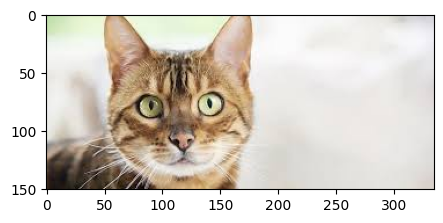

In [4]:
image_name = "../images/cat.jpg"
img = cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = cv2.imread("../images/cat.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

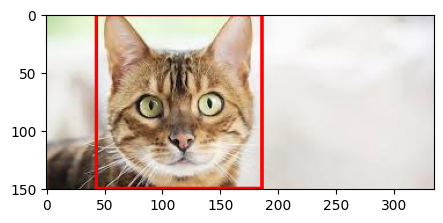

In [5]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalcatface_extended.xml")
results = detector.detectMultiScale(face, 1.1)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x-15, 0), (x+w+15, 150), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()





### Segment the face


In [17]:
# segment out the face using grabcut
st = time.time()
bgModel = np.zeros((1, 65), np.float64)
fgModel = np.zeros((1, 65), np.float64)

face_copy = np.copy(face)




interaction = Interactor(image_name)
start_point, end_point= interaction.get_bbox(image_name)
topleft_c_index, topleft_r_index, w, h = start_point[0], start_point[1], end_point[0] - start_point[0], end_point[1] - start_point[1]


mask = np.zeros(face_copy.shape[:2], np.uint8)
# print("starting grabcut without user brushing, only with user bounding box")
# cv2.grabCut(face_copy, mask, (topleft_c_index, topleft_r_index, w, h), bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

# mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# face_copy = face_copy*mask2[:,:,np.newaxis]
# cv2.imshow("segmentation with only bounding box", face_copy)
# cv2.waitKey(0)

print("now brush the image with the mouse for fg and bg")

mask = interaction.crayon(image_name)
print(mask)

print("starting grabcut with user brushing now")
cv2.grabCut(face_copy, mask, (topleft_c_index, topleft_r_index, w, h), bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
face_copy = face_copy*mask2[:,:,np.newaxis]
print("final segmentation")
cv2.imshow("segmentation post brushing input", face_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

now brush the image with the mouse for fg and bg
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
starting grabcut with user brushing now
final segmentation


0 3


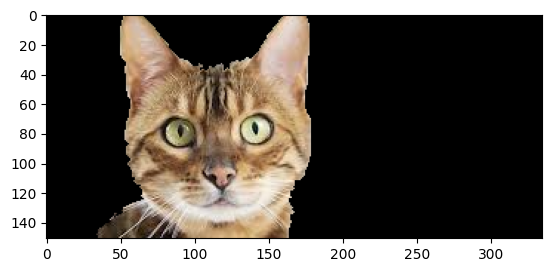

In [19]:
print(np.min(mask), np.max(mask))
# show points where mask == 3

plt.imshow(face_copy, cmap="gray")


#### Smoothen the mask using Gaussian Blurring

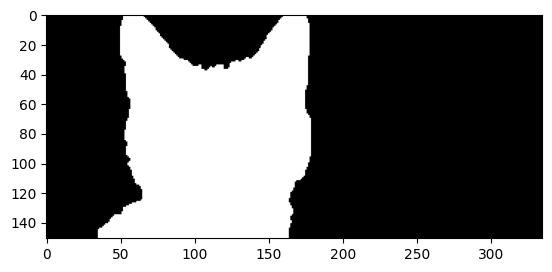

In [20]:
# smoothen the mask with a gaussian filter
mask2 = cv2.GaussianBlur(mask2, (5, 5), 0)
plt.imshow(mask2, cmap='gray')
plt.show()

### Face Landmarks


In [33]:
import cv2
import numpy as np

def store_landmarks(image_path, num_landmarks):
    # Load the image
    image = cv2.imread(image_path)
    image_copy = image.copy()

    # Create a list to store the landmarks
    landmarks = []

    # Create a callback function for mouse events
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Store the coordinates of the clicked point
            landmarks.append((x, y))

            # Draw a circle at the clicked point
            cv2.circle(image_copy, (x, y), 3, (0, 255, 0), -1)

            # Display the image with the clicked points
            cv2.imshow("Image", image_copy)

    # Create a window to display the image
    cv2.namedWindow("Image")
    cv2.setMouseCallback("Image", mouse_callback)

    # Display the image
    cv2.imshow("Image", image_copy)

    # Wait for the user to click on the specified number of landmarks
    while len(landmarks) < num_landmarks:
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

    # Close the window
    cv2.destroyAllWindows()

    # Return the list of landmarks
    return landmarks

# Example usage
image_path = image_name
num_landmarks = 7
landmarks = store_landmarks(image_path, num_landmarks)
print(landmarks)


[(64, 25), (169, 24), (90, 81), (144, 80), (120, 103), (99, 125), (133, 126)]
